# Example of HED shoreline detection

Applying the Holistically-Nested Edge Detection (Xie and Tu, 2015) algorithm to unseen test images.

In [1]:
# magic
%load_ext autoreload
%autoreload 2
%pdb 1
%matplotlib inline

Automatic pdb calling has been turned ON


In [2]:
# imports
from functions.pytorch_models import hed_cnn, Trainer, pretrained_weights, hed_predict
from functions.data_preprocessing import load_images, augment_images_kp, mask_to_uv
from functions.data_preprocessing import load_train_test_imagedata, save_train_test_imagedata
from functions.data_visualisation import plot_predictions, plot_refined_predictions, write_output_gif

import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np

import os, glob

import torch

from sklearn.model_selection import train_test_split

import imgaug as ia
import imgaug.augmenters as iaa

from ipywidgets import interact, fixed, IntSlider, FloatSlider, interact_manual

## Load images
Load images from the ./test_sites/ folder.

In [3]:
# Specify settings
imSize = (320,480) # specify the target image size (height, width)
imDir = './test_sites/*.jpg' # specify the directory with image data

imgPaths = [_ for _ in glob.glob(imDir)]

imData, _ = load_images(imgPaths,imSize)

Loading 22 images...
[====================] 100% - Processing: 22 of 22.Done!


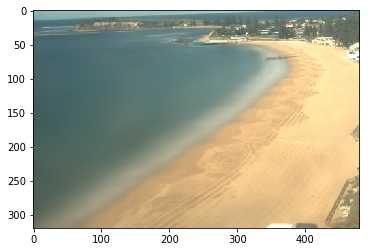

In [4]:
# check the images
ii = 15
plt.imshow(imData[ii])
plt.show()

In [5]:
# final changes to the data
if imData.max() > 1:
    imData = imData/255
imData = torch.from_numpy(imData.transpose((0, 3, 1, 2))).float()

## Apply the model model
1. Load the model and apply pretrained parameters
2. Make predictions for the unseen dataset

In [6]:
# load the model
applyWeights = True
modelSave = 'github'

#pretrained model
weightsPath = './models/shorelineDetectModel_{}.pt'.format(modelSave)

hedModel = hed_cnn()
hedModel = pretrained_weights(hedModel, weightsPath=weightsPath,
                              applyWeights=applyWeights,
                              hedIn=True)

In [7]:
model_pred = hed_predict(hedModel,imData)

## View intermediate model output
View the output of the model from the intermediate layers.

In [8]:
print('Explore model outputs...')
interact(plot_predictions,
         prntNum =IntSlider(
             value=0,
             min=0,
             step=1,
             max=imData.shape[0]-1,
             continuous_update=False,
             description='Image #:',
         ),
         dataX=fixed(imData),
         dataY=fixed(np.zeros(imData.shape)),
         dataPred=fixed(model_pred),
         jj=IntSlider(
             value=2,
             min=0,
             step=1,
             max=5,
             continuous_update=False,
             description='Layer #:',
         ),
         thres=FloatSlider(
             value=0.9,
             min=0.05,
             step=0.05,
             max=0.99,
             continuous_update=False,
             description='Threshold:',
         ),
        )

Explore model outputs...


interactive(children=(IntSlider(value=0, continuous_update=False, description='Image #:', max=21), IntSlider(v…

<function functions.data_visualisation.plot_predictions(prntNum, dataX, dataY, dataPred, jj, thres)>

## View final model output
View final model output

plot_refined_predictions(0,
                         dataX=imData,
                         dataY=np.zeros(imData.shape),
                         dataPred=model_pred,
                         thres=0.85,
                         imReturn=False)

In [11]:
print('Model output...')
interact(plot_refined_predictions,
         prntNum =IntSlider(
             value=0,
             min=0,
             step=1,
             max=imData.shape[0]-1,
             continuous_update=False,
         ),
         dataX=fixed(imData),
         dataY=fixed(np.zeros(imData.shape)),
         dataPred=fixed(model_pred),
         thres=FloatSlider(
             value=0.8,
             min=0.05,
             step=0.05,
             max=0.99,
             continuous_update=False,
         ),
         cvClean=fixed(True),
         imReturn=fixed(False),
        )

Model output...


interactive(children=(IntSlider(value=0, continuous_update=False, description='prntNum', max=21), FloatSlider(…

<function functions.data_visualisation.plot_refined_predictions(prntNum, dataX, dataY, dataPred, thres, cvClean=False, imReturn=False)>

## Write the output to a gif for easy viewing

In [10]:
write_output_gif('./figures/unseen_output.gif', imData, np.zeros(imData.shape), model_pred,0.8,cvClean=True)